# Kaggle Competiton | Telstra Network Disruptions

>We need to build a model to efficiently predict Telstra network's fault severity at a time at a particular location based on the log data available. The log data is splited in several tables therefore we need first to aggregate the data in each table by time (id) and location and merge tables.

>In order to build this model we first need to learn from the data (train data) which features could lead to one decission or the other. We will set up a protocol for processing data and it will be implemented in a pipeline.

>Additionally, we will predict a model with this processed data using the Random Forest classifier and its default parameters. Finally, we will assess the sampling and the accuracy of the predictions by performing Cross Validation and by plotting each confusion matrices.

Go to the official page of the [Kaggle Competition.](https://www.kaggle.com/c/telstra-recruiting-network)

### Goal for this Notebook:
* Aggregate data by time (id) and location in each table
* Merge tables to collect all the features to learn from
* Explore whether or not there are missing values
* Explore how to process the data 
* Develope a protocol for processing data and include it into a pipeline
* Generate a train and a test datasets out of the initial given train data
* Generate a model learning from processed data with the Random Forest classifier and its default parameters
* Apply 3-fold Cross Validation to the train dataset and perform generate three independent predictions
* Evaluate and compare the predictions through confusion matrices

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from scipy import stats
from data_modifier import *

%matplotlib inline

/usr/local/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


### 1. Handle Data

###### Load and Clean Data

In [2]:
event = pd.read_csv("../../../github_data/telstradisr_data/event_type.csv")
log = pd.read_csv("../../../github_data/telstradisr_data/log_feature.csv")
severity = pd.read_csv("../../../github_data/telstradisr_data/severity_type.csv")
resource = pd.read_csv("../../../github_data/telstradisr_data/resource_type.csv")
train = pd.read_csv("../../../github_data/telstradisr_data/train.csv")
test = pd.read_csv("../../../github_data/telstradisr_data/test.csv")

In [3]:
event['event_type'] = event['event_type'].str.split(' ').str[1]
log['log_feature'] = log['log_feature'].str.split(' ').str[1]
severity['severity_type'] = severity['severity_type'].str.split(' ').str[1]
resource['resource_type'] = resource['resource_type'].str.split(' ').str[1]
test['location'] = test['location'].str.split(' ').str[1]
train['location'] = train['location'].str.split(' ').str[1]

We need to merge the tables to build the train and test datasets. 

In [7]:
train.merge(event, left_on='id', right_on='id', how='left').head()

,id,location,fault_severity,event_type
0,14121,118,1,34
1,14121,118,1,35
2,9320,91,0,34
3,9320,91,0,35
4,14394,152,1,35


The events (id and location) can not be repeated when building a model and generate a prediction of the "fault_severity" for each of them. The reason is that we would not have in each row all the information for the event from which we need to learn and the accuracy will significantly decrease. However, our data contain several values of one feature for the same event (time/location).

Hence, we will aggregate the values of those features into dictionaries. Each dictionary will have as keys the values of that feature and as values the number of repetitions of that value for a given event.

The aggregation would be performed for each table individually before merging in order to simplify the process.

###### Aggregate Data

In [8]:
tables = [log,event,severity,resource] 
names = ['log','event','severity','resource'] 
for i in range(len(tables)):
    check = unique_column(tables[i],tables[i].columns[-1])
    
    # AGGREGATE CATEGORICAL VALUES INTO A DICTIO
    if check == False:
        if len(tables[i].columns) == 2:
            a = tables[i].groupby([tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count'})
            a.index.names = ['id','cat']
            a = a.reset_index()
            a = a.set_index('cat')
            
            # check if any value is greater than 1
            #l1 = a[tables[i].columns[-1]]
            #l3 = a[tables[i].columns[-2]]
            #for i in range(len(l1)):
            #    if l3.iloc[i] != 1:
            #        print('more than once',l3.iloc[i])
                    
            # take care that keys are still integers in the dict            
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            tables[i] = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            
        elif len(tables[i].columns) == 3:
            a = tables[i].groupby([tables[i].columns[-3],tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count',tables[i].columns[-2]:'count'})
            a.index.names = ['id','cat1','cat2']
            a = a.reset_index()
            a = a.set_index('cat1')
            b = a.set_index('cat2')
            
            # check if any value is greater than 1
            #l1 = a[tables[i].columns[-1]]
            #l2 = a[tables[i].columns[-3]]
            #l3 = a[tables[i].columns[-2]]
            #print(l1,l2,l3)
            #for i in range(len(l1)):
            #    if l1.iloc[i] != 1:
            #        print('more than once',l2.iloc[i])
            #for i in range(len(l3)):
            #    if l3.iloc[i] != 1:
            #        print('more than once',l2.iloc[i])
        
            # take care that keys are still integers in the dict
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            b = b.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-2]].items()})
            log1 = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            log2 = pd.DataFrame(b,columns=[tables[i].columns[-2]])
event = tables[1]
severity = tables[2]
resource = tables[3]

In [9]:
log1.head()

,volume
id,
1,"{345: 1, 179: 1, 68: 1}"
2,"{312: 1, 233: 1, 235: 1, 315: 1, 313: 1}"
3,{171: 1}
4,{370: 1}
5,"{232: 1, 312: 1}"


In [10]:
event.head()

,event_type
id,
1,"{11: 1, 13: 1}"
2,"{34: 1, 35: 1}"
3,{11: 1}
4,{47: 1}
5,"{34: 1, 35: 1}"


###### Merge Tables into Train and Test Data

In [11]:
train = train.merge(event, left_on='id', right_index=True, how='left')
train = train.merge(severity, left_on='id', right_index=True, how='left')
train = train.merge(resource, left_on='id', right_index=True, how='left')
train = train.merge(log1, left_on='id', right_index=True, how='left')
train = train.merge(log2, left_on='id', right_index=True, how='left')
train.head()

,id,location,fault_severity,event_type,severity_type,resource_type,volume,log_feature
0,14121,118,1,"{34: 1, 35: 1}",{2: 1},{2: 1},"{232: 1, 312: 1}",{19: 1}
1,9320,91,0,"{34: 1, 35: 1}",{2: 1},{2: 1},"{315: 1, 235: 1}","{200: 1, 116: 1}"
2,14394,152,1,"{34: 1, 35: 1}",{2: 1},{2: 1},"{301: 1, 221: 1}",{1: 1}
3,8218,931,1,"{11: 1, 15: 1}",{1: 1},{8: 1},"{80: 1, 82: 1, 203: 1}","{1: 1, 12: 1, 9: 1}"
4,14804,120,0,"{36: 1, 34: 1, 11: 1, 20: 1}",{1: 1},"{8: 1, 2: 1}","{160: 1, 227: 1, 181: 1, 134: 1, 232: 1, 219: ...","{1: 1, 2: 1}"


In [12]:
test = test.merge(event, left_on='id', right_index=True, how='left')
test = test.merge(severity, left_on='id', right_index=True, how='left')
test = test.merge(resource, left_on='id', right_index=True, how='left')
test = test.merge(log1, left_on='id', right_index=True, how='left')
test = test.merge(log2, left_on='id', right_index=True, how='left')
test.head()

,id,location,event_type,severity_type,resource_type,volume,log_feature
0,11066,481,"{34: 1, 35: 1}",{2: 1},{2: 1},"{308: 1, 228: 1, 230: 1, 310: 1}","{24: 1, 20: 1, 26: 1, 28: 1}"
1,18000,962,"{11: 1, 15: 1}",{1: 1},{8: 1},"{82: 1, 203: 1}","{9: 1, 20: 1}"
2,16964,491,"{34: 1, 35: 1}",{2: 1},{2: 1},"{315: 1, 235: 1}","{10: 1, 11: 1}"
3,4795,532,"{10: 1, 27: 1}",{5: 1},"{9: 1, 3: 1}","{240: 1, 37: 1, 38: 1}",{1: 1}
4,3392,600,{15: 1},{2: 1},{8: 1},"{82: 1, 203: 1}","{2: 1, 6: 1}"


###### Split and Check Data

In [56]:
tr_a, te_a = train_test_split(train, train_size = 0.8)
y_train = tr_a.fault_severity
y_test = te_a.fault_severity
tr_a.drop(tr_a.columns[[0,2]], axis=1, inplace=True)
te_a.drop(te_a.columns[[0,2]], axis=1, inplace=True)

In [68]:
tr_a.isnull().sum()

location         0
event_type       0
severity_type    0
resource_type    0
volume           0
log_feature      0
dtype: int64

In [69]:
te_a.isnull().sum()

location         0
event_type       0
severity_type    0
resource_type    0
volume           0
log_feature      0
dtype: int64

In [70]:
nantr = if_nan(tr_a)
nante = if_nan(te_a)
print(nantr,nante)

False False


Once we the datasets with unique events and all the features we want to evaluate how to process the data before learning from it for building a prediction.

In this case the data does not contain NaN or Null values therefore we do not need to replace them. The features are categorical integers in one case with one value per event and in the rest a dictionary with several values per event.

### 2. Analyze Data
* Apply DictVectorizer and OneHotEncoder to generate one feature per each category in the different cases, the first one for dictionary values and the second for integer values
* Generate a quick and dirty first prediction using Random Forest classifier with default parameters

###### Generate a Prediction

In [71]:
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(tr_a,y_train)

pipeline done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

In [72]:
y_predict = call.predict(te_a)

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


### 3. Evaluate model
* Evaluate the prediction by creating a confussion matrix
* Visualize the results by a heatmap of y known vs y predicted

###### Evaluate the prediction

In [73]:
cm1 = confusion_matrix(y_test,y_predict)
cm1

array([[804, 117,  31],
       [182, 182,  15],
       [ 39,  43,  64]])

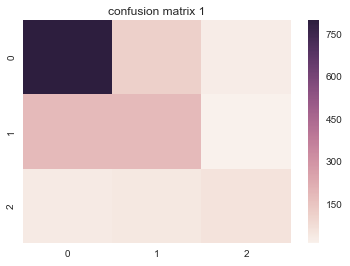

In [74]:
ax = sns.heatmap(cm1)
ax.set_title('confusion matrix 1')

In [75]:
fig = ax.get_figure()
fig.savefig("cm1_preCV.png")

The first class 1 is well predicted whereas the class 2 and 3 is not that much.

#### 3-Fold Cross Validation

In [76]:
tr_a.shape

(5904, 6)

In [77]:
kf = KFold(5904, n_folds=3)
itr = defaultdict(list)
ite = defaultdict(list)
c = 0
for trai, tes in kf:
    print("%s %s" % (trai, tes))
    itr[c] = trai
    ite[c] = tes
    c += 1

[1968 1969 1970 ..., 5901 5902 5903] [   0    1    2 ..., 1965 1966 1967]
[   0    1    2 ..., 5901 5902 5903] [1968 1969 1970 ..., 3933 3934 3935]
[   0    1    2 ..., 3933 3934 3935] [3936 3937 3938 ..., 5901 5902 5903]


#### Data Set 1
* Select the data
* Perform the prediction
* Plot the results in a confusion matrix

In [79]:
x_train1 = tr_a.iloc[itr[0],:]
x_test1 = tr_a.iloc[ite[0],:]
y_train1 = y_train.iloc[itr[0]]
y_test1 = y_train.iloc[ite[0]]

In [80]:
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(x_train1,y_train1)

pipeline done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

In [81]:
y_predict1 = call.predict(x_test1)

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


In [82]:
cm21 = confusion_matrix(y_test1,y_predict1)
cm21

array([[1092,  155,   35],
       [ 196,  269,   29],
       [  69,   44,   79]])

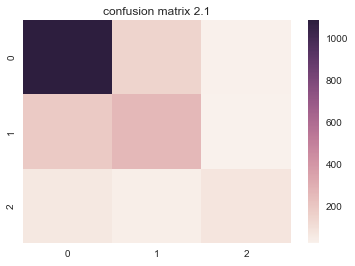

In [83]:
ax = sns.heatmap(cm21)
ax.set_title('confusion matrix 2.1')

In [84]:
fig = ax.get_figure()
fig.savefig("cm21_posCV.png")

#### Data Set 2 
* Select the data
* Perform the prediction
* Plot the results in a confusion matrix

In [86]:
x_train2 = tr_a.iloc[itr[1],:]
x_test2 = tr_a.iloc[ite[1],:]
y_train2 = y_train.iloc[itr[1]]
y_test2 = y_train.iloc[ite[1]]

In [87]:
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(x_train2,y_train2)

pipeline done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

In [88]:
y_predict2 = call.predict(x_test2)

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


In [89]:
cm22 = confusion_matrix(y_test2,y_predict2)
cm22

array([[1110,  153,   30],
       [ 231,  229,   22],
       [  67,   51,   75]])

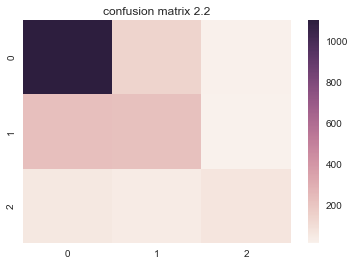

In [90]:
ax = sns.heatmap(cm22)
ax.set_title('confusion matrix 2.2')

In [91]:
fig = ax.get_figure()
fig.savefig("cm22_posCV.png")

#### Data Set 3 
* Select the data
* Perform the prediction
* Plot the results in a confusion matrix

In [92]:
x_train3 = tr_a.iloc[itr[2],:]
x_test3 = tr_a.iloc[ite[2],:]
y_train3 = y_train.iloc[itr[2]]
y_test3 = y_train.iloc[ite[2]]

In [93]:
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(x_train3,y_train3)

pipeline done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

In [94]:
y_predict3 = call.predict(x_test3)

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


In [95]:
cm23 = confusion_matrix(y_test3,y_predict3)
cm23

array([[1051,  167,   39],
       [ 256,  233,   27],
       [  60,   55,   80]])

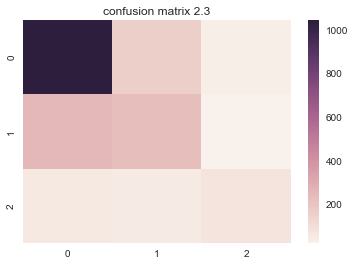

In [96]:
ax = sns.heatmap(cm23)
ax.set_title('confusion matrix 2.3')

In [97]:
fig = ax.get_figure()
fig.savefig("cm23_posCV.png")

The confusion matrices for each of the groups display a good sampling. In the three predictions mainly the class 2 is not well predicted.

In the next notebook (gs_score.ipynb) parameters from Random Forest classifier will be evaluated through Grid Search in order to improve the predictions of class 2 and 3.